In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

plt.rc('figure', figsize=(10, 7))

In [2]:
tf.__version__

'1.1.0-rc2'

## Loading data

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [5]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])

## Data dimensions

In [6]:
img_size = 28
img_size_flat = img_size * img_size
img_shape = [img_size, img_size]
num_classes = 10

## Helper functions

In [7]:
# helper function to plot images
def plot_images(images, cls_true, cls_pred=None):
    img_cnt = len(images)

    # some sanity checks on inputs
    assert img_cnt == len(cls_true)
    if cls_pred is not None:
        assert img_cnt == len(cls_pred)

    # compute plot size. Do not plot more than 100 images
    plt_size = int(np.ceil(np.sqrt(img_cnt)))
    assert plt_size <= 10
    
    fig, axes = plt.subplots(plt_size, plt_size)
    
    # adjust spacing
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    empty_image = np.zeros(img_shape)

    for i, ax in enumerate(axes.flat):
        if i < img_cnt:
            ax.imshow(images[i].reshape(img_shape), cmap='binary')

            if cls_pred is not None:
                xlabel = 'True: {0}, Pred: {1}'.format(cls_true[i], cls_pred[i])
            else:
                xlabel = 'True: {0}'.format(cls_true[i])
        
            ax.set_xlabel(xlabel)
        else:
            ax.imshow(empty_image, cmap='binary')

        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

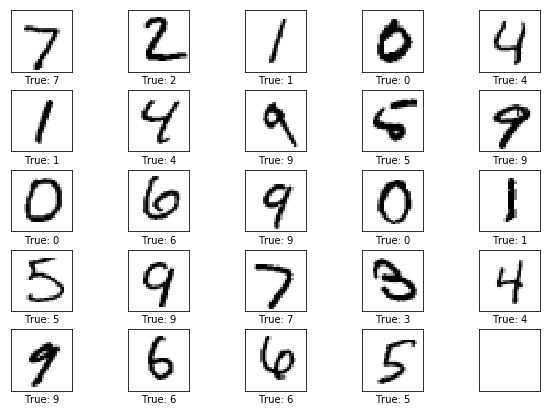

In [8]:
plot_images(data.test.images[0:24], data.test.cls[0:24])

# TensorFlow Graph

## Placeholder variables

In [9]:
x = tf.placeholder(tf.float32, [None, img_size_flat])
y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.int64, [None])

## Weights & biases

In [10]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))
biases = tf.Variable(tf.zeros([num_classes]))

## Model

In [11]:
logits = tf.matmul(x, weights) + biases
y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, dimension=1)

## Cost function

In [12]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_true)
cost = tf.reduce_mean(cross_entropy)

## Opitmization method

In [13]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)
#optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

## Performance measures

In [14]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# TensorFlow Run

## Create a session

In [15]:
session = tf.Session()
session.run(tf.global_variables_initializer())

## Helper function to perform optimization iterations

In [16]:
batch_size = 128
def optimize(iterations):
    for i in range(iterations):
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        feed_dict = {x: x_batch, y_true: y_true_batch}
        session.run(optimizer, feed_dict=feed_dict)

## Helper functions to show performance

In [17]:
feed_dict_test = {x: data.test.images, y_true: data.test.labels, y_true_cls: data.test.cls}

def print_accuracy():
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    print('Accuracy on the test set: {0:.1%}'.format(acc))

def plot_confusion_matrix():
    cls_true = data.test.cls
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)
    print(cm)

    # plot the matrix as an image
    plt.matshow(cm)
    
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.show()

def plot_example_errors(num_errors=16):
    correct, cls_pred = session.run([correct_prediction, y_pred_cls], feed_dict=feed_dict_test)
    
    incorrect = (correct == False)
    images = data.test.images[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = data.test.cls[incorrect]
    
    plot_images(images=images[0:num_errors],
                cls_true=cls_true[0:num_errors],
                cls_pred=cls_pred[0:num_errors])

## Helper function to plot the model's weights

In [18]:
def plot_weights():
    w = session.run(weights)
    w_min = np.min(w)
    w_max = np.max(w)
    
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        if i < 10:
            image = w[:, i].reshape(img_shape)
            ax.set_xlabel('Weights: {0}'.format(i))
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')
        
        ax.set_xticks([])
        ax.set_yticks([])

## Performance before any optimization

In [19]:
print_accuracy()

Accuracy on the test set: 9.8%


[[ 980    0    0    0    0    0    0    0    0    0]
 [1135    0    0    0    0    0    0    0    0    0]
 [1032    0    0    0    0    0    0    0    0    0]
 [1010    0    0    0    0    0    0    0    0    0]
 [ 982    0    0    0    0    0    0    0    0    0]
 [ 892    0    0    0    0    0    0    0    0    0]
 [ 958    0    0    0    0    0    0    0    0    0]
 [1028    0    0    0    0    0    0    0    0    0]
 [ 974    0    0    0    0    0    0    0    0    0]
 [1009    0    0    0    0    0    0    0    0    0]]


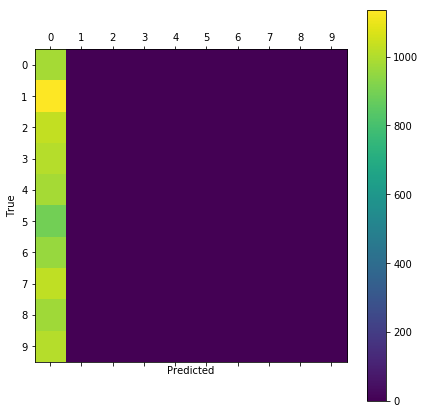

In [20]:
plot_confusion_matrix()

## Performance after one iteration

In [21]:
optimize(iterations=1)

In [22]:
print_accuracy()

Accuracy on the test set: 23.1%


[[ 829    0    0    0    0    0    0  145    6    0]
 [   0    0    0    0    0    0    0  963  172    0]
 [  71    0   15    0    0    0    3  697  246    0]
 [  40    0    0    0    0    5    0  718  247    0]
 [  10    0    0    0    0    0    0  970    2    0]
 [  63    0    0    0    0   52    0  545  232    0]
 [ 170    0    0    0    0    8   21  661   98    0]
 [   0    0    0    0    0    0    0 1021    7    0]
 [  14    0    0    0    0    0    0  590  370    0]
 [   4    0    0    0    0    0    0 1005    0    0]]


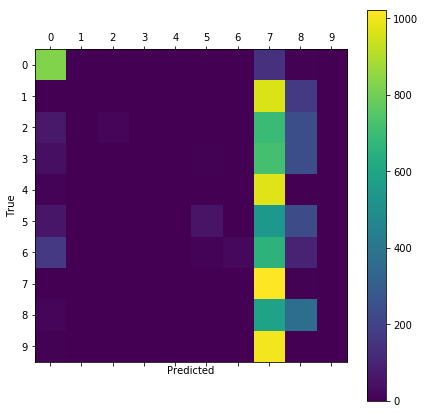

In [23]:
plot_confusion_matrix()

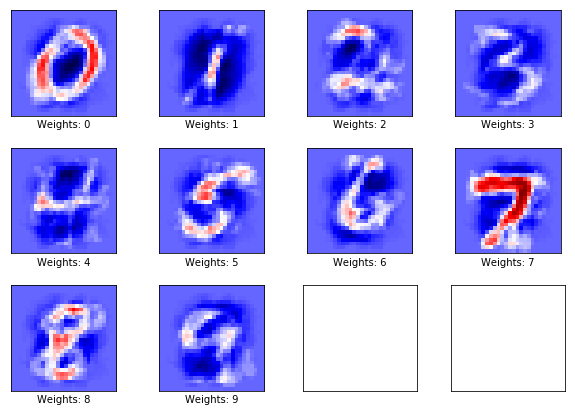

In [24]:
plot_weights()

## Performance after 10 iterations

In [25]:
optimize(iterations=9)

In [26]:
print_accuracy()

Accuracy on the test set: 73.3%


[[ 927    0   12    4    0    0   27    1    9    0]
 [   0 1086   31    2    0    0    4    0   12    0]
 [  33   57  864    5    3    0   32   14   24    0]
 [  18   28   86  790    0    0   12   17   58    1]
 [  13   48   41    8  673    0   99   27   59   14]
 [ 129   55   30  239    7  129   76   36  187    4]
 [  31   22   24    0    1    1  872    1    6    0]
 [  15   65   43    0    1    0    5  893    5    1]
 [  25   54   63   70    3    0   32   21  705    1]
 [  39   41   41   18   64    0   16  342   62  386]]


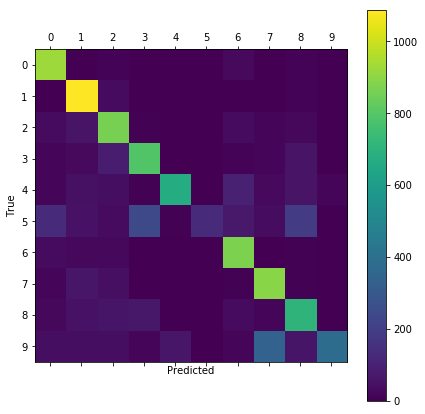

In [27]:
plot_confusion_matrix()

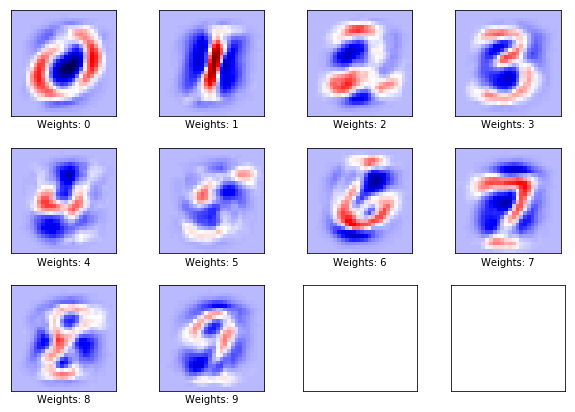

In [28]:
plot_weights()

## Performance after 1000 iterations

In [29]:
optimize(iterations=990)

In [30]:
print_accuracy()

Accuracy on the test set: 91.0%


[[ 959    0    3    2    0    2   10    1    3    0]
 [   0 1103    2    3    1    2    4    1   19    0]
 [  10    9  892   15   14    1   16   18   47   10]
 [   4    1   20  915    1   18    3   14   25    9]
 [   1    3    5    1  912    0   11    1    8   40]
 [  11    6    4   50   14  725   21   11   41    9]
 [  12    3    5    2   12    9  911    1    3    0]
 [   3   19   22    5   10    0    0  930    3   36]
 [   8    9   10   22    8   18   14   15  859   11]
 [  12    8    5   12   43    7    0   22    7  893]]


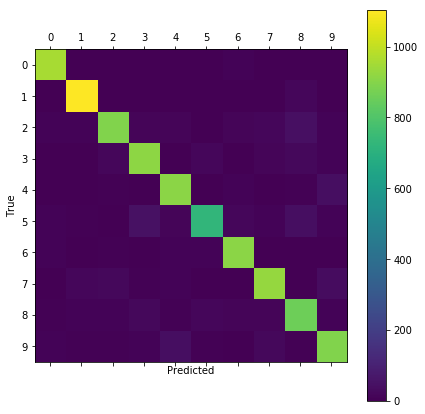

In [31]:
plot_confusion_matrix()

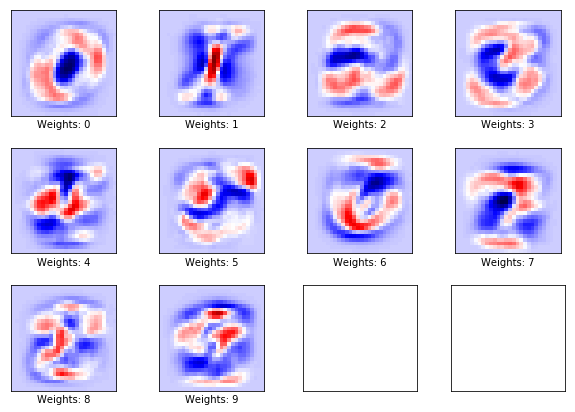

In [32]:
plot_weights()

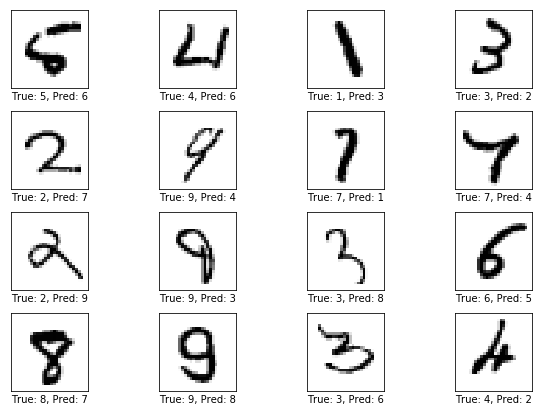

In [33]:
plot_example_errors()

## Performance after 10000 iterations

In [34]:
optimize(iterations=9000)

In [35]:
print_accuracy()

Accuracy on the test set: 92.3%


[[ 960    0    2    2    0    4    9    1    2    0]
 [   0 1110    2    2    0    1    4    2   14    0]
 [   5    7  923   18    8    6   11    9   38    7]
 [   2    0   21  922    0   26    1   10   20    8]
 [   1    2    5    1  911    0   12    4    9   37]
 [   9    3    4   34    9  774   16    7   29    7]
 [  10    3    5    2    9   16  906    3    4    0]
 [   1    6   21   10    6    1    0  946    2   35]
 [   6    7    7   26    9   28   10   10  864    7]
 [  10    7    2   10   28    7    0   25    9  911]]


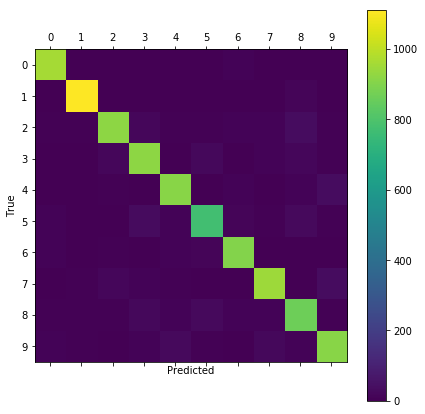

In [36]:
plot_confusion_matrix()

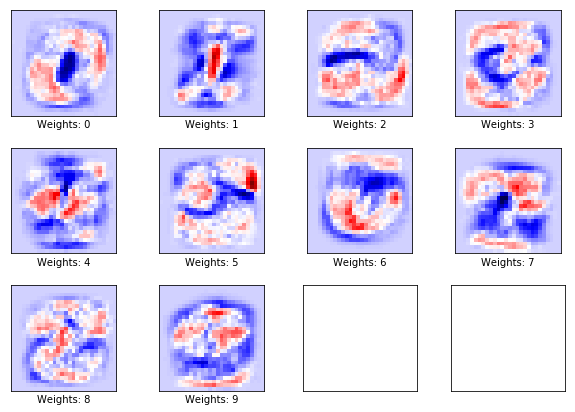

In [37]:
plot_weights()

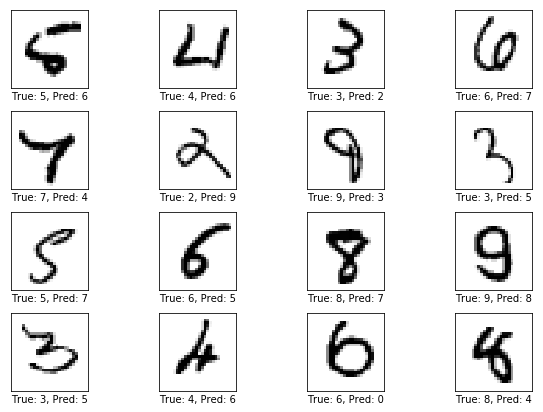

In [38]:
plot_example_errors()